## Τα Στοιχεία μου
ΤΥΠΑΛΔΟΣ-ΠΑΥΛΟΣ ΑΠΟΣΤΟΛΑΤΟΣ 1115201800009



# Initialisation

In [ ]:
!pip install transformers
!pip install wandb

In [5]:
!pip install simpletransformers

     |████████████████████████████████| 248 kB 4.8 MB/s 
     |████████████████████████████████| 9.7 MB 17.1 MB/s 
     |████████████████████████████████| 1.2 MB 34.6 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 311 kB 42.9 MB/s 
     |████████████████████████████████| 133 kB 44.2 MB/s 
     |████████████████████████████████| 1.1 MB 14.7 MB/s 
     |████████████████████████████████| 243 kB 43.9 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 271 kB 44.1 MB/s 
     |████████████████████████████████| 144 kB 46.4 MB/s 
     |████████████████████████████████| 4.3 MB 38.3 MB/s 
     |████████████████████████████████| 164 kB 43.3 MB/s 
     |████████████████████████████████| 76 kB 4.6 MB/s 
     |████████████████████████████████| 111 kB 44.9 MB/s 
     |████████████████████████████████| 128 kB 43.3 MB/s 
     |████████████████████████████████| 792 kB 43.7 MB/s 
     |███████████████

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import nltk
import re
from gensim.models import Word2Vec
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix,classification_report
from gensim.parsing.preprocessing import remove_stopwords
import urllib.request
from scipy import spatial
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
drive.mount('/content/drive')

import sys, os
from statistics import mean
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from torch.autograd import Variable
from torchtext import legacy
from tqdm import tqdm



from transformers import BertTokenizer
from transformers import BertModel
import json
import logging
from simpletransformers.question_answering import QuestionAnsweringModel, QuestionAnsweringArgs
from transformers import BertForQuestionAnswering

path = "/content/drive/MyDrive/AI2/" #update this
#path = "C:/Users/Pavlos/Desktop/AI2/" #update this
quick_execution=False #update this to True to make all epochs of every model to be quick_global_epoch 
quick_global_epoch=30


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_df = pd.read_csv(path + "vaccine_train_set.csv",index_col=0)
validation_set = pd.read_csv(path + "vaccine_validation_set.csv",index_col=0) # and this. only those 2 needed to run your own test csv
print(train_df)
print(validation_set)
# print(validation_set.iat[0,0])

                                                   tweet  label
0      Sip N Shop Come thru right now #Marjais #Popul...      0
1      I don't know about you but My family and I wil...      1
2      @MSignorile Immunizations should be mandatory....      2
3      President Obama spoke in favor of vaccination ...      0
4      "@myfoxla: Arizona monitoring hundreds for mea...      0
...                                                  ...    ...
15971  @Salon if u believe the anti-vax nutcases caus...      1
15972  How do you feel about parents who don't #vacci...      0
15973  70 Preschoolers Tested for Measles in Simi Val...      0
15974  Finance Minister: Budget offers room to procur...      0
15975  Are you up to date on vaccines? Take CDC’s vac...      2

[15976 rows x 2 columns]
                                                  tweet  label
0     @user They had a massive surge in with covid d...      1
1     Required vaccines for school: Parents and guar...      0
2     “@KCStar: T

In [5]:
train_df['tweet'] = train_df['tweet'].apply(lambda x: x.lower())
# train_df['tweet'] = train_df['tweet'].apply(lambda x: tokenize(x))
train_df['tweet'] = train_df['tweet'].apply(lambda x: re.sub(r'\W', ' ', x))
train_df['tweet'] = train_df['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))

validation_set['tweet'] = validation_set['tweet'].apply(lambda x: x.lower())
# validation_set['tweet'] = validation_set['tweet'].apply(lambda x: tokenize(x))

validation_set['tweet'] = validation_set['tweet'].apply(lambda x: re.sub(r'\W', ' ', x))
validation_set['tweet'] = validation_set['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))


In [6]:
train_df = train_df.drop(train_df[train_df.tweet.str.len() < 2].index)
validation_set = validation_set.drop(validation_set[validation_set.tweet.str.len() < 2].index)

## Αφαίρεση stopwords
i.e “a”, “the”, “is” etc

In [7]:

train_df['tweet'] = train_df['tweet'].apply(lambda x: remove_stopwords(x))
validation_set['tweet'] = validation_set['tweet'].apply(lambda x: remove_stopwords(x))


# Οπτικοποίηση Δεδομένων

In [8]:
print("test set Examples:")
pd.DataFrame(train_df['tweet']).head(10)

test set Examples:


,tweet
0,sip n shop come right marjais popularnobodies ...
1,t know family covid19 vaccine anytime soon
2,msignorile immunizations mandatory period okla...
3,president obama spoke favor vaccination childr...
4,myfoxla arizona monitoring hundreds measles li...
5,whooping cough vaccine day bring baby home t l...
6,prosecutor ken ervin want know recklessly kill...
7,uberfacts average people complain live longer ...
8,legacy jennymccarthy took clothes contributed ...
9,uberfacts average people complain live longer ...


In [9]:
print("validation set Examples:")
pd.DataFrame(validation_set['tweet']).head(10)
# values, counts = np.unique(validation_set['label'], return_counts=True)
# print(values, counts )

validation set Examples:


,tweet
0,user massive surge covid deaths immediately va...
1,required vaccines school parents guardians chi...
2,kcstar johnson county children measles http t ...
3,nv better states best worst vaccinating kids h...
4,like killing w fear mt alyssa_milano vaccine f...
5,m subscribing panic du jour s measles remember...
6,801punx fav songs check aptbs exploding head a...
7,happend covid 19 vaccine test candidates died ...
8,zenith bs gt gt cdc says ebola vaccine works w...
9,dlockyer second occurrence read vaccines harmi...


##GPU

εγώ δούλεψα κυρίως σε google colab αλλα μεταφέρω τους tensors στην gpu για να υποστηρίξω τοπική χρήση pytorch. στον δικο μου υπολογιστή είδα γυρω στο 10% μείωση ταχύτητας

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
      
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
# train_loader = DeviceDataLoader(train_loader, device)
# val_loader = DeviceDataLoader(val_loader, device)
device = get_default_device()
device
cpudevice =torch.device('cpu')

In [12]:
device

device(type='cuda')

In [11]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

tensor([[  101,  1045,  2097,  3422,  2033, 23065,  3892,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [13]:

example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] i will watch memento tonight [SEP] [PAD] [PAD]


In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
labels = {'neutral':0,
          'anti-vax':1,
          'pro-vax':2
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = list(labels.values())
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['tweet']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
list(labels.values())

[0, 1, 2]

In [15]:
class BertClassifier(nn.Module):

    def __init__(self,num_classes, dropout=0.3):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [16]:
tokens_train = tokenizer.batch_encode_plus(
    train_df['tweet'].tolist(),
    return_tensors="pt",
    max_length = 25,
    padding='max_length',
    pad_to_max_length=True,
    truncation=True
)



# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    validation_set['tweet'].tolist(),
    return_tensors="pt",
    padding='max_length',
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [17]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_df['label'].tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(validation_set['label'].tolist())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

In [18]:
batch_size = 64
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)


# dataLoader for train set
train_iterator = DataLoader(train_data,  batch_size=batch_size,shuffle=True)

# wrap tensors
val_data = TensorDataset(test_seq, test_mask, test_y)


# dataLoader for validation set
valid_iterator = DataLoader(val_data, batch_size=batch_size,shuffle=True)

##NEURAL NETWORKS

θα δειτε στην 1 σειρα τα διαγράματα του W2vec και στη 2η του GloVe.αριστερά με το class net1 και δεξιά με το net2

In [25]:
num_classes = 3
learning_rate = 1e-4
model = BertClassifier(num_classes)
loss_func=F.cross_entropy
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
num_classes = 3
learning_rate = 1e-4
model = BertClassifier(num_classes)
loss_func=F.cross_entropy
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
train, test = Dataset(train_df), Dataset(validation_set)
train_iterator = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
valid_iterator = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
for batch in train_iterator:
  print(batch)
  break

[tensor([[  101,  4283,  2475,  ..., 19817,  2226,   102],
        [  101,  2053, 11514,  ...,     0,     0,     0],
        [  101,  1019, 16725,  ...,  2891,  3501,   102],
        ...,
        [  101,  5242, 26629,  ...,  2509, 19966,   102],
        [  101,  9064, 10372,  ...,  2595, 19716,   102],
        [  101,  2852, 29045,  ...,  2273,  2075,   102]]), tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), tensor([2, 1, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0,
        2, 0, 0, 1, 1, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 1,
        2, 0, 0, 2, 1, 2, 2, 0, 1, 0, 0, 0, 2, 2, 0, 2])]


In [ ]:
for train_input, train_label in train_iterator:
  print(train_input)
  break

NameError: ignored

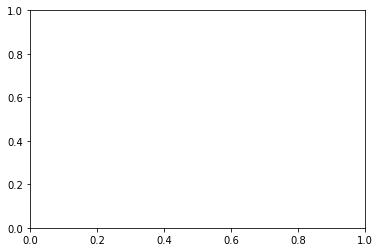

In [7]:


#Initialize dataloader
# plt.subplot(2,2,1)
fig, ax = plt.subplots(1,1)
k=0
store_final=[]
# for embd,(vocab_size,vocabulary) in  enumerate(zip([len(TEXT.vocab)],[TEXT.vocab.vectors])):#pick word embedding


# num_hidden = 50
# num_layers = 2
# #Define Hyperparameters
#Initialize model, loss, optimizer
for i,(CELL_TYPE,clip_by_value) in enumerate(zip(['vanilla'],[True])):
  to_device(model,device)
  train_iterator=DeviceDataLoader(train_iterator,device)
  valid_iterator=DeviceDataLoader(valid_iterator,device)
  # to_device(train_iterator,device)
  # to_device(valid_iterator,device)

  # to_device(loss_func,device)
  train_losses=[]
  test_losses=[]
  final_output=[]
  final_ypred = []
  final_label= []
  epochs=10
  for epoch in tqdm(range(epochs)):
    model.train()#train mode allows for gradient and hyper parameter optimisation.torch.optim takes model.parameters() so it can know which parameters to tweak and which not
    batch_losses = []
    for batch in train_iterator:
      # print( x_batch.shape)

      input_id, mask, labels = batch

      # train_label = train_label.to(device)
      # mask = train_input['attention_mask'].to(device)
      # input_id = train_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)
      # print(output.shape)
      pred_probab = nn.Softmax(dim=1)(output)#activation function
      y_pred = pred_probab.argmax(1)
      loss = loss_func(output, labels) #models always output a one hot vector while y_batch is class number i.e 0 1 2
      batch_losses.append(loss.item())
      
      #Delete previously stored gradients
      optimizer.zero_grad()
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      if (clip_by_value):
      # Gradient Norm Clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
      else:  
      #Gradient Value Clipping
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
    
    # print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainloader):.5f}")
    train_losses.append(sum(batch_losses)/len(train_iterator))
    with torch.no_grad():
      model.eval()#this eval/test mode will stop the model from training itself for the test dataset by locking down the model parameters and not doing backward probagation
      # scores=[]
      batch_losses = []
      for batch in valid_iterator:
        # val_label = val_label.to(device)
        # mask = val_input['attention_mask'].to(device)
        # input_id = val_input['input_ids'].squeeze(1).to(device)

        input_id, mask, labels = batch

        output = model(input_id, mask)
        pred_probab = nn.Softmax(dim=1)(output)
        y_pred = pred_probab.argmax(1)
        if epoch==epochs-1:#for the final epoch combine the results and store them(the final epoch will have the best results)
          final_output += output
          final_ypred += y_pred
          final_label += labels
        loss = loss_func(output, labels)
        batch_losses.append(loss.item())
      test_losses.append(sum(batch_losses)/len(valid_iterator))
  store_final.append((final_output,final_ypred,final_label))
  k=k+1
  for metric,metric_name in zip([f1_score(torch.tensor(final_label),torch.tensor(final_ypred),average='macro' ),recall_score (torch.tensor(final_label),torch.tensor(final_ypred),average='macro' ) ,precision_score(torch.tensor(final_label),torch.tensor(final_ypred),average='macro' )], ["F measure =","recall score =","precision score ="]):
    plt.scatter([epochs], [metric])
    plt.annotate(metric_name, (epochs, metric))
  plt.plot(range(epochs), train_losses)
  plt.plot(range(epochs), test_losses)
  plt.legend(['train', 'test'])
  plt.xlabel("epochs")
  plt.ylabel("Loss")
  plt.title(CELL_TYPE)#plot loss vs epochs graph and point the prediction accuracy scores
fig.set_figwidth(10)
fig.set_figheight(4*2)
plt.tight_layout()
plt.show()

roc curves για τα παραπανω μοντέλα με σείρα απο αριστερά προς δεξιά και  πάνω προς κάτω

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


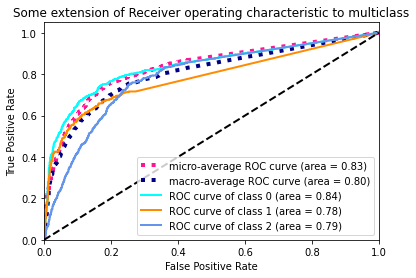

              precision    recall  f1-score   support

  neutral(0)      0.795     0.741     0.767      1065
 anti-vax(1)      0.471     0.584     0.522       296
  pro-vax(2)      0.685     0.686     0.686       921

    accuracy                          0.699      2282
   macro avg      0.650     0.671     0.658      2282
weighted avg      0.709     0.699     0.702      2282



In [27]:
def show_roc():
  num_curves=len(store_final)
  for i in range(num_curves):
    final_output,final_ypred,final_label=store_final[i]
    final_label=[l.cpu() for l in final_label]
    f =[o.tolist() for o in final_output]
    f
    fn = np.array(f)
    fn
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test=label_binarize(final_label, classes=[0, 1, 2])# roc curve function requires one-hot vectors
    y_score=fn
    n_classes=num_classes
    for i in range(n_classes):
        # print(y_test[:, i])#oi ploiades poy einai pragmati tis classis i exoyn 1/true
        # print(y_score[:, i])#oi ploiades poy NOMIZOYN oti einai tis classis i exoyn 1/true
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    # plt.subplot(1, num_curves, i)
    # plt.figure(figsize=(10,10))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
  plt.show()

def report():
  num_curves=len(store_final)
  for i in range(num_curves):
    final_output,final_ypred,final_label=store_final[i]
    final_label=[l.cpu() for l in final_label]
    final_ypred=[l.cpu() for l in final_ypred]
    print(classification_report(final_label, final_ypred, digits=3,target_names=['neutral(0)','anti-vax(1)','pro-vax(2)']))

# print(store_final)
show_roc()
report()

##PART 2

In [8]:
import json
with open( path+"train-v2.0.json", "r") as read_file:
    train = json.load(read_file)
with open( path +"dev-v2.0.json", "r") as read_file:
    test = json.load(read_file)

In [35]:
print(json.dumps(train, indent=1, sort_keys=True))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
model_type="bert"
model_name= "bert-base-uncased"

In [10]:
# Configure the model 
model_args = QuestionAnsweringArgs()
model_args.train_batch_size = 16
model_args.evaluate_during_training = True
model_args.n_best_size=3
model_args.num_train_epochs=5


In [11]:
### Advanced Methodology
train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "use_cached_eval_features": True,
    "output_dir": f"outputs/{model_type}",
    "best_model_dir": f"outputs/{model_type}/best_model",
    "evaluate_during_training": True,
    "max_seq_length": 128,
    "num_train_epochs": 5,
    "evaluate_during_training_steps": 1000,
    "wandb_project": "Question Answer Application",
    "wandb_kwargs": {"name": model_name},
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "n_best_size":3,
    # "use_early_stopping": True,
    # "early_stopping_metric": "mcc",
    # "n_gpu": 2,
    # "manual_seed": 4,
    # "use_multiprocessing": False,
    "train_batch_size": 64,
    "eval_batch_size": 64,
    # "config": {
    #     "output_hidden_states": True
    # }
}

In [12]:
model = QuestionAnsweringModel(
    model_type,model_name, args=train_args
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [16]:
# Train the model
model.train_model(train['data']['paragraphs'], eval_data=test['data']['paragraphs'])

TypeError: ignored

roc curves για τα παραπανω μοντέλα με σείρα απο αριστερά προς δεξιά και  πάνω προς κάτω